### New Import

In [1]:
!pip install git+https://github.com/cubecloud/fool_game.git@feature-02-np-exp

  Cloning https://github.com/cubecloud/fool_game.git (to revision feature-02-np-exp) to /tmp/pip-req-build-mcgqg_zm
  Running command git clone -q https://github.com/cubecloud/fool_game.git /tmp/pip-req-build-mcgqg_zm
  Running command git checkout -b feature-02-np-exp --track origin/feature-02-np-exp
  Switched to a new branch 'feature-02-np-exp'
  Branch 'feature-02-np-exp' set up to track remote branch 'feature-02-np-exp' from 'origin'.
  Created wheel for fool-game: filename=fool_game-0.1.16-cp37-none-any.whl size=23784 sha256=24bc43c3828df72b90d185a7f6df9bd50bc72bf5360c9e4e92f977e54ce64f8f
  Stored in directory: /tmp/pip-ephem-wheel-cache-knhwjs00/wheels/8f/3d/c8/ca35378aa7396c2a96c1c7ff84439121e8a8de5ab1c26111f5
Successfully built fool-game


In [ ]:
# !git clone --branch='feature-02-np-exp'  https://github.com/cubecloud/fool_game.git
# !pip install /content/fool_game/

In [17]:
# adding terra_ai location for using googlesync 
# for development on local drive and testing 
# in google colab or jupyter notebook 
# change this variables to your locations for development
local_drive = '/home/cubecloud/GDrive'
remote_drive = '/content/drive/MyDrive'
local_dev = '/Python/fool_game/'
remote_dev = '/Python/fool_game/'
__demo_version__ = "0.1.0"
import sys
if 'google.colab' in str(get_ipython()):
    print('Running on CoLab')
#     from google.colab import drive
#     drive.mount('/content/drive')
    DEV = f'{remote_drive}{remote_dev}'
    DRIVE = remote_drive
elif 'ipykernel' in str(get_ipython()):
    print('Running on Jupyter Notebook')
    DEV = f'{local_drive}{local_dev}'
    DRIVE = local_drive
else:
    sys.exit('Not running on CoLab or Jupyter notebook')
print(f'Adding sys path: {DEV}')
sys.path.append(DEV)
HOME = f'{DEV}data/'

#check environment 

import tensorflow
print('Checking key environment depenndecies')
!python --version
print('TensorFlow', tensorflow.__version__)
print('Keras', tensorflow.keras.__version__)


Running on CoLab
Adding sys path: /content/drive/MyDrive/Python/fool_game/
Checking key environment depenndecies
Python 3.7.10
TensorFlow 2.3.0
Keras 2.4.0


In [18]:
# import collections
import numpy as np # импортируем библиотеку для работы с массивами данных
import tensorflow as tf
# from tensorflow.keras.models import Model, load_model 
# from tensorflow.keras import layers
# from tensorflow.keras.layers import Dense, Flatten, Input, Lambda, Conv2D, MaxPooling2D, Reshape, Multiply # из кераса загружаем необходимые слои для нейросети
# from tensorflow.keras.layers import BatchNormalization
# from tensorflow.keras.optimizers import RMSprop, Adam, SGD, RMSprop# из кераса загружаем выбранный оптимизатор
import time                                # модуль для операций со временными характеристиками
import matplotlib.pyplot as plt            # импортируем библиотеку для визуализации данных
import seaborn as sns
import matplotlib
import pandas as pd
import pickle as pkl
import random
import sys
import os
from datetime import datetime, timedelta
from IPython.display import clear_output 

import pytz
timezone = pytz.timezone("Europe/Moscow")
# # "магическая" команда python для запуска библиотеки в ноутбуке
# %matplotlib inline

HOME = f'/content/drive/MyDrive/Python/fool_game/data/'
from google.colab import drive
drive.mount('/content/drive')

from importlib import reload
from cardgames import foolgame
foolgame = reload(foolgame)
print(tf.__version__)
print(tf.keras.__version__)
print(foolgame.__version__)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
2.3.0
2.4.0
0.01.16


### Figshow

In [19]:
def figshow(df):
    fig = plt.figure(figsize=(26, 7))
    sns.set_style("white")
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.set_axisbelow(True)
    ax1.minorticks_on()
    ax1.grid(which='major', linestyle='-', linewidth='0.5', color='gray')
    ax1.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
    # last_game = int(df["game"].max())
    # N = np.arange(0, last_game+1)

    plt.plot(df["game_episode"], df["loss"], linestyle='--', color='blue', label="loss")
    plt.plot(df["game_episode"], df["epsilon"], linestyle='--', color='green', label="epsilon")
    plt.title(f"Loss & epsilon")
    plt.legend()

    ax2 = fig.add_subplot(1, 2, 2)
    ax2.set_axisbelow(True)
    ax2.minorticks_on()
    ax2.grid(which='major', linestyle='-', linewidth='0.5', color='gray')
    ax2.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
    plt.plot(df["game_episode"], df['mean_reward'], linestyle='-', color='red', label="best_mean_reward")
    # plt.plot(df["game_episode"], df["time"]/10, linestyle='--', color='green', label="time/10")
    # plt.title(f"mean_reward & time/10")
    plt.title(f"mean_reward")
    plt.legend()
    plt.show()
    pass

In [20]:
!nvidia-smi

Tue May  4 11:06:00 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    33W / 250W |    407MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [21]:
games_num = 100000
players_num = 4

model = foolgame.q_model_dense(in_shape=(37, 20+players_num,), num_actions=37)
model_target = foolgame.q_model_dense(in_shape=(37, 20+players_num,), num_actions=37)

game_table = foolgame.Environment(players_num, games_num, model)

In [22]:
MEAN_REWARD_BOUND = 0.9           

gamma = 0.99                                   
batch_size = 32                 # at epoch = 1000
replay_size = 10000                
       
sync_target_turns = 3000        # at turn_idx = 3000 
replay_start_size = 10000      
eps_start = 1.0
eps_decay = .999985             #changed start from .999985
eps_min = 0.02                  # changed from 0.02 to 0.07 and at epoch=1000 to 0.1
epsilon_greedy_frames = 1000000.0

In [23]:
model_weights_save_name = 'fool_cardgame_weights'
history_csv_name = 'fool_cardgame_hst.csv'
exp_pkl_name = 'fool_cardgame_exp.pkl'
cols = ['game_episode',
        'turns',  
        'time', 
        'loss',
        'epsilon',
        'mean_reward',
       ]

def get_pd_data(pdfile):
  df_data = pd.read_csv(os.path.join(HOME, pdfile), index_col=0)
  return df_data

def add_data_to_pd(df_data, _game_episode, _turns, _time, _loss, _epsilon, _mean_reward):
  df_data = df_data.append({'game_episode': _game_episode,
                            'turns': _turns,
                            'time': _time,
                            'loss': _loss,
                            'epsilon': _epsilon,
                            'mean_reward': _mean_reward,
                            }, ignore_index=True)
  # print(self.df.to_string())
  return df_data
  
def load_checkpoint(save_name):
    pd_file_path =  os.path.join(HOME, history_csv_name)
    if os.path.exists(pd_file_path):    
      df = get_pd_data(pd_file_path)
      pd_start_game= int(df.game_episode.max())
    else:
      pd_start_game = 0
      df = pd.DataFrame(columns=cols)
    start_game = 0
    mean_reward = 0
    dirlist = os.listdir(HOME)
    for i in range (len(dirlist)):
      filename = dirlist[i]
      if save_name in filename:
        if '_' in filename: 
          try: 
            epoch = int((filename.split('_')[-1]).split('.')[-2])
          except ValueError:
            epoch = 0
          if epoch > start_game:
            start_game = epoch
    if pd_start_game > start_game:
      df.drop(index = [i for i in range(start_game+1, pd_start_game+1)], axis=0, inplace=True)
      # df.to_csv(os.path.join(HOME, history_csv_name), encoding='utf-8')
    if start_game > 0:
      file_path = os.path.join(HOME, f'{save_name}_{start_game}.h5')
      model.load_weights(file_path)
      model_target.load_weights(file_path)
      print(f"Loaded {file_path} save, for model & model_target. Starting training from {start_game}")
      # last epoch +1
      epsilon = float(df.loc[(df["game_episode"]==start_game), "epsilon"].item())
      mean_reward = float(df.loc[(df["game_episode"]==start_game), "mean_reward"].item())
    else:
      epsilon = 1.0
      print(f"Starting from scratches. Starting game = {start_game}")
    return df, start_game, epsilon, mean_reward

df, start_game, epsilon, mean_reward = load_checkpoint(model_weights_save_name)

if start_game != 0:
  turn_idx = int(df.turns.max())
  figshow(df)
  game_episode = start_game
  total_rewards = []
  total_rewards = df.loc[(df["game_episode"]<=start_game) &(df["game_episode"]>=start_game-100), "mean_reward"].values.tolist()
  # epsilon = 0.1
  learning_rate = 1e-4
  adam_hat = 1e-8
  if game_episode > 200:
    lr_decay = 60/game_episode
    learning_rate = learning_rate * lr_decay
    if learning_rate < adam_hat:
      learning_rate = adam_hat
else:
  turn_idx = 0
  mean_reward = 0
  game_episode = -1
  epsilon = eps_start
  total_rewards = []
  learning_rate = 1e-4  

print(df.tail(15).to_string())
print(f'Start game episode:', start_game)
print('Turn index:', turn_idx)
print('Epsilon:', epsilon)
print('Learning rate:', learning_rate)
print('Mean reward on last game episode:', mean_reward)
print(f'_mean_ of Total rewards for last 100 games: {np.mean(total_rewards[-100:]) if total_rewards else None}')

exp_file_path = os.path.join(HOME, f'{exp_pkl_name}')
if start_game != 0:
  if os.path.exists(exp_file_path):
    game_table.replay_buffer.load(exp_file_path)
  else:
    msg = f"Warning: pickle Exp file not found, starting without" 
    print(msg)

time_sum = int(df["time"].sum())
print(f'Model learning {start_game} games and {timedelta(seconds=time_sum)}')

Starting from scratches. Starting game = 0
   game_episode  turns      time  loss   epsilon  mean_reward
0           0.0   30.0  0.362964   0.0  0.999985     0.333333
Start game episode: 0
Turn index: 0
Epsilon: 1.0
Learning rate: 0.0001
Mean reward on last game episode: 0
_mean_ of Total rewards for last 100 games: None
Model learning 0 games and 0:00:00


>>>Training starts at  2021-05-04 14:07:24.737124+03:00
game_episode: 000000000000, turn: 0000023, epsilon: 1.000, mean reward: 0.667, rewards in row 0.6667, loss: 0.0000, replay_buffer 23. Best mean reward updated 0.667, time: 1.4627 sec


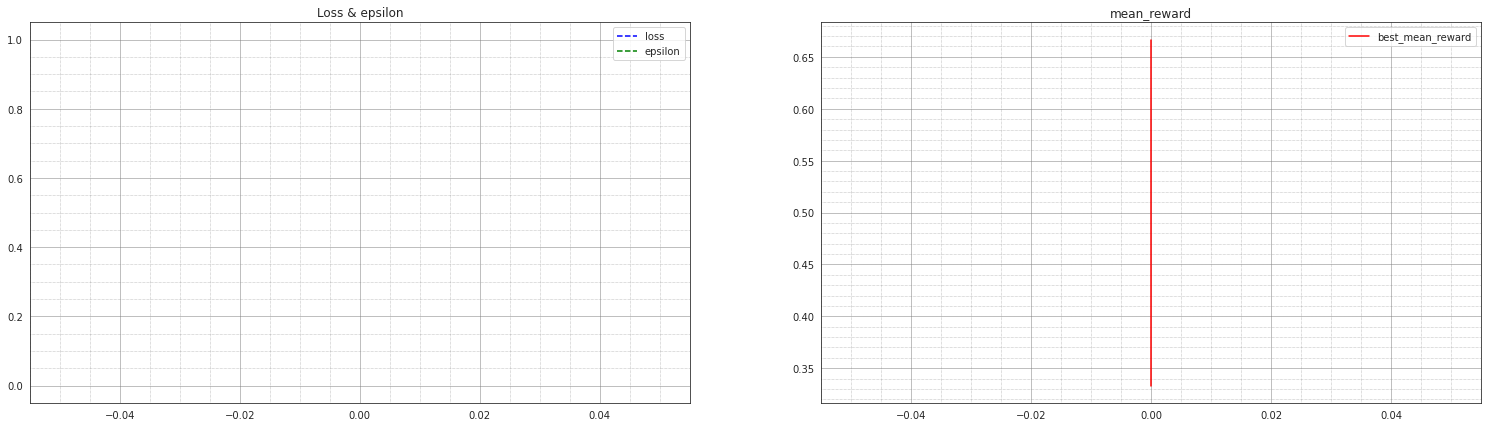

game_episode: 000000000010, turn: 0000489, epsilon: 1.000, mean reward: 0.576, rewards in row 2.6667, loss: 0.0000, replay_buffer 489, time: 0.0717 sec
game_episode: 000000000020, turn: 0000938, epsilon: 1.000, mean reward: 0.571, rewards in row 2.3333, loss: 0.0000, replay_buffer 938, time: 0.3518 sec
game_episode: 000000000030, turn: 0001318, epsilon: 1.000, mean reward: 0.581, rewards in row 2.3333, loss: 0.0000, replay_buffer 1318, time: 0.0791 sec
game_episode: 000000000040, turn: 0001772, epsilon: 0.999, mean reward: 0.569, rewards in row 0.6667, loss: 0.0000, replay_buffer 1772, time: 1.1421 sec
game_episode: 000000000050, turn: 0002104, epsilon: 0.999, mean reward: 0.621, rewards in row 2.6667, loss: 0.0000, replay_buffer 2104, time: 0.8416 sec
game_episode: 000000000060, turn: 0002561, epsilon: 0.999, mean reward: 0.623, rewards in row 2.0000, loss: 0.0000, replay_buffer 2561, time: 0.3026 sec
game_episode: 000000000070, turn: 0002920, epsilon: 0.999, mean reward: 0.620, rewar

InvalidArgumentError: ignored

In [25]:
# optimizer = keras.optimizers.Adam(learning_rate=0.00025) # added back clipnorm (was deleted)
# loss_funct = tf.keras.losses.Huber(delta=1.2)   # changet at epoch 1100 from 1.3
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=1.0)
# optimizer = keras.optimizers.SGD(learning_rate=learning_rate,
#                                   momentum=0.9,
#                                   nesterov=True) # added back clipnorm (was deleted
# optimizer = Adam(learning_rate=learning_rate)
# loss_funct = tf.keras.losses.Huber(delta=1.5)   # changet at epoch 1100 from 1.3

# optimizer = Adam(lr=learning_rate)
loss_funct = tf.keras.losses.Huber()

model.compile(optimizer = optimizer,
              loss = loss_funct,
              metrics=['mean_square_error'])

model_target.compile(optimizer = optimizer,
                    loss = loss_funct,
                    metrics=['mean_square_error'])


best_mean_reward = None
num_actions = 37
loss_numpy = 0
loss = 0
rewards_in_row = []
total_games_count = 0
start_datetime = datetime.now(timezone)
print(">>>Training starts at ", start_datetime)
game_table.prepare_new_game()
ai_repeat = 'new'
start_time = time.time()
while True:
#         game_table.verbose = True
        if ai_repeat == 'new':
            game_table.first_game = True
            game_table._reset()
        reward, episode_buffer = game_table.train_episode_AI(start_type=ai_repeat, epsilon=epsilon)
        rewards_in_row.append(reward)
        if len(rewards_in_row) > 12:
          del rewards_in_row[:1]
        if reward == 0:
            ai_repeat = 'same'
            continue
        else:
            if reward != 1.0:
                ai_repeat = 'same'
            else:
                ai_repeat = 'new'
            epsilon = max(epsilon*eps_decay, eps_min)
            game_table.replay_buffer.extend(episode_buffer)
            game_episode += 1
            total_games_count +=1
            turn_idx += game_table.game_turns
            total_rewards.append(reward)
            mean_reward = np.mean(total_rewards[-100:])
            if len(total_rewards) > 100:
              del total_rewards[:1]
            msg = f"\rgame_episode: {game_episode:012d}, turn: {turn_idx:07d}, epsilon: {epsilon:.3f}, " \
                  f"mean reward: {mean_reward:.3f}, rewards in row {np.sum(rewards_in_row[-12:]):.4f}, loss: {loss_numpy:.4f}, " \
                  f"replay_buffer {len(game_table.replay_buffer)}"
         
            if best_mean_reward is None or best_mean_reward < mean_reward:
                best_mean_reward = mean_reward
                if best_mean_reward is not None:
                    msg = f'{msg}. Best mean reward updated {best_mean_reward:.3f}'

            if mean_reward > MEAN_REWARD_BOUND and len(game_table.replay_buffer) > replay_start_size:
                end_time = time.time()
                game_time = end_time - start_time 
                start_time  = time.time()


                print(f'{msg}, time: {game_time:.4f} sec')    
                print("Solved in %d turns!" % turn_idx)
                if tf.is_tensor(loss):
                   loss_numpy = tf.keras.backend.get_value(loss)
                df = add_data_to_pd(df, game_episode, turn_idx, game_time, loss_numpy, epsilon, mean_reward)
                df.to_csv(os.path.join(HOME, history_csv_name), encoding='utf-8')
                break
            
            if tf.is_tensor(loss):
                loss_numpy = tf.keras.backend.get_value(loss)    

            end_time = time.time()
            game_time = end_time - start_time 
            start_time  = time.time()
            if game_episode % 10 == 0:
              print(f'{msg}, time: {game_time:.4f} sec')
            df = add_data_to_pd(df, game_episode, turn_idx, game_time, loss_numpy, epsilon, mean_reward)
            if (game_episode % 200 == 0) and (game_episode != 0):
                df.to_csv(os.path.join(HOME, history_csv_name), encoding='utf-8')
            if (game_episode % 500 == 0) and (game_episode != 0) and (turn_idx >= replay_start_size):
                print('Saving weights...')
                model.save_weights(os.path.join(HOME, f'{model_weights_save_name}_{game_episode:002d}.h5'))
                game_table.replay_buffer.save(exp_file_path)
            if game_episode % 400 == 0:
                figshow(df)
            elif (game_episode % 1500 == 0) and (game_episode != 0):  
                clear_output()
                print(df.tail(50).to_string())
                figshow(df)

        if len(game_table.replay_buffer) < replay_start_size:
            continue

        batch = game_table.replay_buffer.sample(batch_size)
        states, actions, rewards, dones, next_states = batch

        # Build the updated Q-values for the sampled future states
        # Use the target model for stability
        future_rewards = model_target.predict(next_states)
        # Q value = reward + discount factor * expected future reward
        updated_q_values = rewards + gamma * tf.reduce_max(
            future_rewards, axis=1
        )

        # If final turn set the last value to -1
        updated_q_values = updated_q_values * (1 - dones) - dones

        # Create a mask so we only calculate loss on the updated Q-values
        masks = tf.one_hot(actions, num_actions)

        with tf.GradientTape() as tape:
            # Train the model on the states and updated Q-values
            q_values = model(states)

            # Apply the masks to the Q-values to get the Q-value for action taken
            q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
            # Calculate loss between new Q-value and old Q-value
            loss = loss_funct(updated_q_values, q_action)

        # Backpropagation
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        if turn_idx % sync_target_turns == 0:
            # update the the target network with new weights
            model_target.set_weights(model.get_weights())

print('Saving weights...')
model.save_weights(os.path.join(HOME, f'{model_weights_save_name}_{game_episode:002d}.h5'))
game_table.replay_buffer.save(exp_file_path)
figshow(df)

end_datetime = datetime.now(timezone)
print(">>>Training ends at ", end_datetime)
train_time = start_datetime-end_datetime
print(f'Model trained:', timedelta(days=train_time))


## Сыграем эпизод обученной моделью и воспроизведем видео

In [ ]:
from datetime import datetime, timedelta
from IPython.display import clear_output 

num_actions = 4
model_weights_save_name = 'q_deep_model_weights'
optimizer = Adam(lr=0.0001)
loss_funct = tf.keras.losses.Huber()

model = create_q_model(num_actions)

model.compile(optimizer = optimizer,
              loss = loss_funct,
              metrics=['mean_absolute_error'])
 
def load_checkpoint(model, save_name):
    start_game = 0
    dirlist = os.listdir(HOME)
    for i in range (len(dirlist)):
      filename = dirlist[i]
      if save_name in filename:
        if '_' in filename: 
          try: 
            epoch = int((filename.split('_')[-1]).split('.')[-2])
          except ValueError:
            epoch = 0
          if epoch > start_game:
            start_game = epoch

    if start_game > 0:
      file_path = os.path.join(HOME, f'{save_name}_{start_game}.h5')
      
      model.load_weights(file_path)
      print(f"Loaded {file_path} save. Last game {start_game}")
      # last epoch +1
    else:
      print(f"Weights not found!")
    return model, start_game

model, start_game = load_checkpoint(model, model_weights_save_name)

Loaded /content/drive/MyDrive/Colab Notebooks/data/dz32/q-deep/q_deep_model_weights_2100.h5 save. Last game 2100


In [ ]:
###########################
# Импорт библиотек для записи и воспроизведения видео
###########################
!pip install pyvirtualdisplay > /dev/null 2>&1 
# Устанавливаем виртуальный дисплей pyvirtualdisplay; "/dev/null 2>&1" уберёт длинный вывод в строке output
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1 # создает вирт.дисплей в памяти(нужен для работы дисплея в ноутбуке)
# "apt-get..." - установка пакета программного обеспечения
# "...-y..." автоматический "yes" на вопрос "вы действительно хотите это установить?" 
# "...xvfb..." - бэкенд для pyvirtualdisplay - сервер, который выполняет все графические операции в памяти без вывода на экран
# "...python-opengl..." - поддержка графики с помощью графической библиотеки
# "...ffmpeg" - пакеты для обработки/конвертирования видеофайла из одного формата в другой
 
# from gym.wrappers import Monitor # класс Monitor из пакета функций-обёрток в gym активирует видеозапись игры
import glob   # модуль возвращает список путей к видео по шаблону (для удобства поиска/воспроизведения текущего видео)
import base64 # библиотека поможет нам закодировать видео в 64-разрядный код, и без повреждений/изменений открыть его в ноутбуке через HTML
 
from IPython.display import HTML              # загружаем модуль чтобы обратиться к HTML для открытия закодированного видео 
from IPython import display as ipythondisplay # активирует дисплей для воспроизведения видео в интерфейсе ноутбука
from pyvirtualdisplay import Display          # модуль для активации виртуального дисплея
display = Display(visible=0, size=(1400, 900))# запустим невидимый виртуальный дисплей
display.start()

In [ ]:
###########################
# Задаем функции записи и воспроизведения видео
###########################
def wrapEnv(env):                           # зададим функцию-обёртку над средой
  env = gym.wrappers.Monitor(env, './video', force=True) # класс Monitor будет записывать игру в видеофайл
  return env                                # теперь вызов среды через функцию wrapEnv будет запускать видеозапись
 
def showVideo():                            # функция для воспроизведения видео в ноутбуке
  mp4list = glob.glob('video/*.mp4')        # возвращает список путей к видео по этому шаблону
  if len(mp4list) > 0:                      # если по этому пути нашелся хотя бы один файл
    mp4 = mp4list[0]                        # то берём самый свежий файл
    video = open(mp4, 'r+b').read()         # открываем в режиме чтения/записи бинарного файла
    encoded = base64.b64encode(video)       # кодируем видео в 64-разрядный код 
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    # Декодируем ascii формат в видео mp4 - "format(encoded.decode('ascii'))))"
    # для воспроизведения на разных браузерах - "<source src="data:video/mp4"
    # задаём высоту экрана 400px - "height: 400px;"
    # активируем элементы управления в видео(типа кнопки паузы и т.п) - "controls"
    # включаем автоповтор после окончания воспроизведения - "loop"
    # видео автоматически воспроизведется по готовности - "autoplay"
    # текстовая альтернатива описывающая объект в случае невозможности отображения - "alt="test""
    
  else:                           # если путь не нашелся 
    print("Could not find video") # то выведем на печать, что не смог найти видео

In [ ]:
DEFAULT_ENV_NAME ='Pong-v0'
def play_episode(model): # подаем на вход функции модель нейросети
    FPS = 25
    env = make_env(DEFAULT_ENV_NAME)
    env = wrapEnv(env)              # создаем среду в режиме записи
    
    done = False                       # игровой эпизод не завершён
    # observation = env.reset()          # задаем начальное состояние среды, которое наблюдает агент
    # newObservation = observation       # задали новое состояние которое наблюдает агент
    state = env.reset()
    total_reward = 0.0
    while done == False:               # пока игровой эпизод не завершён
        start_ts = time.time()
        env.render() 
        state_a = np.array(state, copy=False)
        state_tensor = tf.convert_to_tensor(state_a)
        state_tensor = tf.expand_dims(state_tensor, 0)
        action_probs = model.predict(state_tensor)
        # Take best action
        action = tf.argmax(action_probs[0]).numpy()

        state, reward, done, _ = env.step(action)
        total_reward += reward

        if done:
            break
        delta = 1/FPS - (time.time() - start_ts)
        if delta > 0:
            time.sleep(delta)
        # env.render()                   # запускаем воспроизведение среды
    env.close() # закрываем игровую среду после окончания игры
    print(f'Total reward: {total_reward:.2f}')
    showVideo() # показать видео игры

In [ ]:
# Взглянем как сыграет сетка, обученная на 1910 тренировках
# model.load_weights(os.path.join(HOME, f'{model_weights_save_name}_1140.h5')) # подгружаем модель из сохранённых
play_episode(model)                     # запускаем игровой эпизод

Total reward: 17.00
